In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.metrics import make_scorer, classification_report, accuracy_score, make_scorer, roc_auc_score, average_precision_score, confusion_matrix, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
credit_df = pd.read_csv('train.csv')
credit_df.head()

In [ ]:
credit_df['Credit_Score'].value_counts()

Standard    53174
Poor        28998
Good        17828
Name: Credit_Score, dtype: int64

In [ ]:
credit_df.count()

ID                          100000
Customer_ID                 100000
Month                       100000
Name                         90015
Age                         100000
SSN                         100000
Occupation                  100000
Annual_Income               100000
Monthly_Inhand_Salary        84998
Num_Bank_Accounts           100000
Num_Credit_Card             100000
Interest_Rate               100000
Num_of_Loan                 100000
Type_of_Loan                 88592
Delay_from_due_date         100000
Num_of_Delayed_Payment       92998
Changed_Credit_Limit        100000
Num_Credit_Inquiries         98035
Credit_Mix                  100000
Outstanding_Debt            100000
Credit_Utilization_Ratio    100000
Credit_History_Age           90970
Payment_of_Min_Amount       100000
Total_EMI_per_month         100000
Amount_invested_monthly      95521
Payment_Behaviour           100000
Monthly_Balance              98800
Credit_Score                100000
dtype: int64

In [ ]:
credit_df.nunique(axis=0)

ID                          100000
Customer_ID                  12500
Month                            8
Name                         10139
Age                           1788
SSN                          12501
Occupation                      16
Annual_Income                18940
Monthly_Inhand_Salary        13235
Num_Bank_Accounts              943
Num_Credit_Card               1179
Interest_Rate                 1750
Num_of_Loan                    434
Type_of_Loan                  6260
Delay_from_due_date             73
Num_of_Delayed_Payment         749
Changed_Credit_Limit          4384
Num_Credit_Inquiries          1223
Credit_Mix                       4
Outstanding_Debt             13178
Credit_Utilization_Ratio    100000
Credit_History_Age             404
Payment_of_Min_Amount            3
Total_EMI_per_month          14950
Amount_invested_monthly      91049
Payment_Behaviour                7
Monthly_Balance              98792
Credit_Score                     3
dtype: int64

In [ ]:
credit_df.isnull().sum()

ID                              0
Customer_ID                     0
Month                           0
Name                         9985
Age                             0
SSN                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       15002
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                11408
Delay_from_due_date             0
Num_of_Delayed_Payment       7002
Changed_Credit_Limit            0
Num_Credit_Inquiries         1965
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age           9030
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      4479
Payment_Behaviour               0
Monthly_Balance              1200
Credit_Score                    0
dtype: int64

In [ ]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

# Data Preprocessing

-Handle missing values in name column by looking up customer_id and using the name that belongs to the corresping id

In [ ]:
all_Customer_ID = credit_df[credit_df['Name'].isnull()]['Customer_ID'].values
print(type(all_Customer_ID))
print(all_Customer_ID.shape)
#print(len(all_Customer_ID))
for id in all_Customer_ID:
  name = credit_df.loc[(credit_df['Customer_ID'] == id) & (credit_df['Name'].notna())]['Name'].values[0]
  credit_df.loc[(credit_df['Customer_ID'] == id) & (credit_df['Name'].isna()), ['Name']] = name

<class 'numpy.ndarray'>
(9985,)


In [ ]:
credit_df[credit_df['Customer_ID'] == 'CUS_0x132f']['Name']

160    Mark Felsenthald
161    Mark Felsenthald
162    Mark Felsenthald
163    Mark Felsenthald
164    Mark Felsenthald
165    Mark Felsenthald
166    Mark Felsenthald
167    Mark Felsenthald
Name: Name, dtype: object

-Remove any additional characters in the age field i.e. '_', convert age field to type int, replace abnormal ages with the correct age of the person, looking up corresponding customer_id

In [ ]:
#credit_df['Age'] = [str(s).replace('_', '') for s in credit_df['Age']]
#for val in credit_df['Age']:
#  credit_df['Age'] = str(val).replace('_', '')
credit_df['Age'] = [str(val).replace('_', '') for val in credit_df['Age']]
credit_df['Age'] = credit_df['Age'].astype(int)
abnormal_ages= credit_df[(credit_df['Age'] < 10) | (credit_df['Age'] > 70)]['Customer_ID'].values
print(abnormal_ages.shape)
for id in abnormal_ages:
    age = credit_df[credit_df['Customer_ID'] ==id]['Age'].drop_duplicates().values[0]
    if age < 10 or age > 70:
        age = credit_df[credit_df['Customer_ID'] ==id]['Age'].drop_duplicates().values[1]
    credit_df.loc[(credit_df['Customer_ID'] == id) & ((credit_df['Age'] < 10) | (credit_df['Age'] > 70)), ['Age']] = age

(2781,)


In [ ]:
credit_df[credit_df['Customer_ID'] == 'CUS_0x5407']['Age']

56    30
57    30
58    30
59    30
60    30
61    30
62    30
63    30
Name: Age, dtype: int64

Replace occupation of '______' with the correct occupation of the applicant by looking up the corresponding customer_id

In [ ]:
print(credit_df['Occupation'].isnull().sum())
credit_df[credit_df['Occupation'] == '_______']

0


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
8,0x160e,CUS_0x21b1,January,Rick Rothackerj,28,004-07-5839,_______,34847.84,3037.986667,2,...,Good,605.03,24.464031,26 Years and 7 Months,No,18.816215,104.291825168246,Low_spent_Small_value_payments,470.69062692529184,Standard
16,0x161a,CUS_0x2dbc,January,Langep,34,486-85-3974,_______,143162.64,12187.220000,1,...,Good,1303.01,28.616735,17 Years and 9 Months,No,246.992319,168.413702679309,!@9#%8,1043.3159778669492,Good
18,0x161c,CUS_0x2dbc,March,Langep,34,486-85-3974,_______,143162.64,NaN,1,...,Good,1303.01,26.519815,17 Years and 11 Months,No,246.992319,__10000__,High_spent_Small_value_payments,715.741367403555,Good
20,0x161e,CUS_0x2dbc,May,Langep,34,486-85-3974,_______,143162.64,12187.220000,1,...,Good,1303.01,31.376150,18 Years and 1 Months,No,246.992319,430.9475278803298,Low_spent_Large_value_payments,810.7821526659284,Good
29,0x162b,CUS_0xb891,June,Jasond,55,#F%$D@*&8,_______,30689.89,2612.490833,2,...,_,632.46,27.445422,17 Years and 8 Months,No,16.415452,84.95284817115969,High_spent_Small_value_payments,419.8807835023488,Standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99920,0x25f7a,CUS_0x2654,January,enj,37,647-67-8889,_______,139664.96,11777.746667,3,...,_,365.66,31.043048,29 Years and 7 Months,Yes,423.731016,282.78234595777644,High_spent_Large_value_payments,711.261305,Standard
99935,0x25f8d,CUS_0xb11c,August,Yinka Adegokej,38,546-94-4789,_______,15319.65,1460.637500,6,...,Bad,1453.61,34.557510,11 Years and 4 Months,Yes,28.182033,191.87777851803025,Low_spent_Small_value_payments,216.003938,Poor
99937,0x25f93,CUS_0xad4f,February,Sabina Zawadzkig,47,226-45-0652,_______,22620.79,1722.065833,7,...,Standard,642.46,31.841872,NaN,No,0.000000,105.07629339039072,Low_spent_Large_value_payments,337.13029,Standard
99943,0x25f99,CUS_0xad4f,August,Sabina Zawadzkig,48,226-45-0652,_______,22620.79,NaN,6,...,_,642.46,34.026427,29 Years and 10 Months,No,0.000000,205.21728040016708,Low_spent_Small_value_payments,256.989303,Poor


In [ ]:
credit_df[credit_df['Customer_ID'] == 'CUS_0x4d43']['Occupation']

200    Entrepreneur
201         _______
202         _______
203    Entrepreneur
204    Entrepreneur
205    Entrepreneur
206    Entrepreneur
207    Entrepreneur
Name: Occupation, dtype: object

In [ ]:
empty_occupations = credit_df[credit_df['Occupation']== '_______']['Customer_ID'].values
for id in empty_occupations:
  occupation = credit_df[credit_df['Customer_ID'] ==id]['Occupation'].drop_duplicates().values[0]
  if occupation == '_______':
    occupation = credit_df[credit_df['Customer_ID'] ==id]['Occupation'].drop_duplicates().values[1]
  credit_df.loc[(credit_df['Customer_ID'] == id) & (credit_df['Occupation'] == '_______'), ['Occupation']] = occupation

In [ ]:
credit_df[credit_df['Customer_ID'] == 'CUS_0x4d43']['Occupation']

200    Entrepreneur
201    Entrepreneur
202    Entrepreneur
203    Entrepreneur
204    Entrepreneur
205    Entrepreneur
206    Entrepreneur
207    Entrepreneur
Name: Occupation, dtype: object

Remove any additional characters in the annual_income field
i.e. '_', convert annual_income field to type float, replcae annual_income outliers by using the correct annual income from the corresponding customer_id

In [ ]:
credit_df['Annual_Income'] = [str(val).replace('_', '') for val in credit_df['Annual_Income']]
credit_df['Annual_Income'] = credit_df['Annual_Income'].astype(float)

In [ ]:
#credit_df.nlargest(5000, ['Annual_Income'])['Customer_ID']
credit_df[credit_df['Annual_Income'] > 500000]['Customer_ID']
credit_df[credit_df['Annual_Income'] < 5000]['Customer_ID']

Series([], Name: Customer_ID, dtype: object)

In [ ]:
outlier_salary = credit_df[credit_df['Annual_Income']> 100000]['Customer_ID'].values
for id in outlier_salary:
    income = credit_df[credit_df['Customer_ID'] ==id]['Annual_Income'].min()
    credit_df.loc[(credit_df['Customer_ID'] ==id) &
              (credit_df['Annual_Income']> 100000), ['Annual_Income']] = income

In [ ]:
credit_df[credit_df['Customer_ID'] == 'CUS_0x1748']['Annual_Income']

15688    179987.28
15689    179987.28
15690    179987.28
15691    179987.28
15692    179987.28
15693    179987.28
15694    179987.28
15695    179987.28
Name: Annual_Income, dtype: float64

Replace null values with the correct monthly salary by looking up the corresponding customer_id

In [ ]:
print('Null monthly salary count = ',credit_df['Monthly_Inhand_Salary'].isnull().sum())
credit_df['Monthly_Inhand_Salary'].replace(np.nan, -1.0, inplace=True)
null_msalary = credit_df[credit_df['Monthly_Inhand_Salary']==-1.0]['Customer_ID'].values
for id in null_msalary:
  salary = credit_df[credit_df['Customer_ID'] == id]['Monthly_Inhand_Salary'].drop_duplicates().values[0]
  #salary=credit_df[credit_df['Customer_ID'] ==
   #               id]['Monthly_Inhand_Salary'].drop_duplicates().sort_values().values[-1]
  if salary == -1.0:
    salary = credit_df[credit_df['Customer_ID'] == id]['Monthly_Inhand_Salary'].drop_duplicates().values[1]
  credit_df.loc[(credit_df['Customer_ID'] == id) & (credit_df['Monthly_Inhand_Salary'] == -1.0), ['Monthly_Inhand_Salary']] = salary


Null monthly salary count =  15002


In [ ]:
credit_df[credit_df['Customer_ID'] == 'CUS_0xd40']['Monthly_Inhand_Salary']

0    1824.843333
1    1824.843333
2    1824.843333
3    1824.843333
4    1824.843333
5    1824.843333
6    1824.843333
7    1824.843333
Name: Monthly_Inhand_Salary, dtype: float64

In [ ]:
print('Null monthly salary count = ',credit_df['Monthly_Inhand_Salary'].isnull().sum())
print(credit_df[credit_df['Monthly_Inhand_Salary'] == -1.0].size)

Null monthly salary count =  0
0


Replace abnormal bank account values with the correct value for the applicant by looking up corresponding customer_id

In [ ]:
credit_df[(credit_df['Num_Bank_Accounts'] > 7) |
        (credit_df['Num_Bank_Accounts'] < 0)]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
56,0x1656,CUS_0x5407,January,Annk,30,500-92-6408,Media_Manager,34081.38,2611.115000,8,...,Standard,1704.18,24.448063,NaN,NM,70.478333,162.4410091967751,Low_spent_Large_value_payments,298.19215813115227,Poor
57,0x1657,CUS_0x5407,February,Annk,30,500-92-6408,Media_Manager,34081.38,2611.115000,8,...,_,1704.18,35.171160,14 Years and 8 Months,Yes,70.478333,38.4369827577036,High_spent_Large_value_payments,392.19618457022375,Poor
58,0x1658,CUS_0x5407,March,Annk,30,500-92-6408,Media_Manager,34081.38,2611.115000,8,...,Standard,1704.18,35.111552,14 Years and 9 Months,Yes,70.478333,199.7207654954979,Low_spent_Large_value_payments,260.9124018324295,Poor
59,0x1659,CUS_0x5407,April,Annk,30,500-92-6408,Media_Manager,34081.38,2611.115000,8,...,_,1704.18,29.762159,14 Years and 10 Months,Yes,70.478333,220.55219192916718,Low_spent_Small_value_payments,260.0809753987602,Poor
60,0x165a,CUS_0x5407,May,Annk,30,500-92-6408,Media_Manager,34081.38,2611.115000,8,...,_,1704.18,30.206214,14 Years and 11 Months,Yes,70.478333,NaN,High_spent_Large_value_payments,397.2283547370202,Standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99987,0x25fdd,CUS_0x8600,April,Sarah McBridec,28,031-35-0942,Architect,20002.88,1929.906667,10,...,_,3571.7,30.614953,5 Years and 11 Months,Yes,60.964772,43.72461709437765,High_spent_Large_value_payments,328.301277,Standard
99988,0x25fde,CUS_0x8600,May,Sarah McBridec,28,#F%$D@*&8,Architect,20002.88,1929.906667,10,...,_,3571.7,28.508250,6 Years and 0 Months,Yes,60.964772,213.97800979403817,Low_spent_Small_value_payments,208.047884,Standard
99989,0x25fdf,CUS_0x8600,June,Sarah McBridec,28,031-35-0942,Architect,20002.88,1929.906667,10,...,Bad,3571.7,33.359987,6 Years and 1 Months,Yes,60.964772,74.36660309585342,!@9#%8,307.659291,Standard
99990,0x25fe0,CUS_0x8600,July,Sarah McBridec,28,031-35-0942,Architect,20002.88,1929.906667,10,...,Bad,3571.7,25.123535,NaN,Yes,60.964772,173.2755025599617,Low_spent_Large_value_payments,228.750392,Standard


In [ ]:
abnormal_accounts = credit_df[(credit_df['Num_Bank_Accounts'] > 7) |(credit_df['Num_Bank_Accounts'] < 0)]['Customer_ID'].values

for id in abnormal_accounts:
    numAccounts = credit_df[credit_df['Customer_ID'] == id]['Num_Bank_Accounts'].drop_duplicates().values[0]
    if numAccounts < 0 or numAccounts > 11:
        numAccounts = credit_df[credit_df['Customer_ID'] == id]['Num_Bank_Accounts'].drop_duplicates().values[1]
    credit_df.loc[(credit_df['Customer_ID'] == id) & (
        (credit_df['Num_Bank_Accounts'] < 0) | (credit_df['Num_Bank_Accounts'] > 11)), ['Num_Bank_Accounts']] = numAccounts

In [ ]:
credit_df[credit_df['Customer_ID'] == 'CUS_0x96ca']['Num_Bank_Accounts']

20256    10
20257    10
20258    10
20259    10
20260    10
20261    10
20262    10
20263    10
Name: Num_Bank_Accounts, dtype: int64

In [ ]:
print('Null credit card count = ',credit_df['Num_Credit_Card'].isnull().sum())

Null credit card count =  0


In [ ]:
credit_df['Num_Credit_Card'] = [str(val).replace('_', '') for val in credit_df['Num_Credit_Card']]
credit_df['Num_Credit_Card'] = credit_df['Num_Credit_Card'].astype(int)

In [ ]:
#credit_df[(credit_df['Num_of_Loan'] > 10) |(credit_df['Num_of_Loan'] <= 0)]
print(credit_df[credit_df['Num_Credit_Card'] < 0].size)
credit_df[credit_df['Customer_ID'] == 'CUS_0x4100']['Num_Credit_Card']

0


152       7
153       7
154       7
155       7
156       7
157    1029
158       7
159       7
Name: Num_Credit_Card, dtype: int64

In [ ]:
abnormal_cc = credit_df[credit_df['Num_Credit_Card'] > 7]['Customer_ID'].values
#print(abnormal_cc.size)
for id in abnormal_cc:
    #print(credit_df[credit_df['Customer_ID'] == id]['Num_Credit_Card'])
    cc = credit_df[credit_df['Customer_ID'] == id]['Num_Credit_Card'].drop_duplicates().values[0]
    if cc > 15:
        cc = credit_df[credit_df['Customer_ID'] == id]['Num_Credit_Card'].drop_duplicates().values[1]
    credit_df.loc[(credit_df['Customer_ID'] == id) & (
        (credit_df['Num_Credit_Card'] < 0) | (credit_df['Num_Credit_Card'] > 11)), ['Num_Credit_Card']] = cc

In [ ]:
credit_df[credit_df['Customer_ID'] == 'CUS_0x9bc1']['Num_Credit_Card']

336    3
337    3
338    3
339    3
340    3
341    3
342    3
343    3
Name: Num_Credit_Card, dtype: int64

In [ ]:
credit_df['Interest_Rate'] = [str(val).replace('_', '') for val in credit_df['Interest_Rate']]
credit_df['Interest_Rate'] = credit_df['Interest_Rate'].astype(int)

In [ ]:
print(credit_df[credit_df['Interest_Rate'] <= 0].size)
print('Null interest rate count = ',credit_df['Interest_Rate'].isnull().sum())

0
Null interest rate count =  0


In [ ]:
credit_df[credit_df['Customer_ID'] == 'CUS_0x56c5']['Interest_Rate']
credit_df[credit_df['Customer_ID'] == 'CUS_0xc365']['Interest_Rate']


2712       5
2713       5
2714       5
2715    2197
2716       5
2717       5
2718       5
2719    2701
Name: Interest_Rate, dtype: int64

In [ ]:
print(credit_df[credit_df['Interest_Rate'] > 100]['Customer_ID'].values.size)
print(credit_df[credit_df['Interest_Rate'] > 100]['Customer_ID'].unique().size)
print(credit_df[credit_df['Customer_ID'] == 'CUS_0x1915']['Interest_Rate'])

2012
1889
70152    4182
70153    4488
70154      20
70155      20
70156      20
70157      20
70158      20
70159      20
Name: Interest_Rate, dtype: int64


In [ ]:
abnormal_interest = credit_df[credit_df['Interest_Rate'] > 100]['Customer_ID'].values
for id in abnormal_interest:
  if credit_df[credit_df['Customer_ID'] == id]['Interest_Rate'].drop_duplicates().values.size > 1:
    rate = credit_df[credit_df['Customer_ID'] == id]['Interest_Rate'].drop_duplicates().values[0]
    if rate > 100:
          rate = credit_df[credit_df['Customer_ID'] == id]['Interest_Rate'].drop_duplicates().values[1]
    credit_df.loc[(credit_df['Customer_ID'] == id) & (
        (credit_df['Interest_Rate'] < 0) | (credit_df['Interest_Rate'] > 11)), ['Interest_Rate']] = rate
  #else:
    #print(credit_df[credit_df['Customer_ID'] == id]['Interest_Rate'])
mean_interest = credit_df[credit_df['Interest_Rate'] <= 100]['Interest_Rate'].values

In [ ]:
print(credit_df[credit_df['Customer_ID'] == 'CUS_0xac67']['Interest_Rate'])

17880    936
17881    936
17882    936
17883    936
17884    936
17885    936
17886    936
17887    936
Name: Interest_Rate, dtype: int64


In [ ]:
credit_df['Num_of_Loan'] = [str(val).replace('_', '') for val in credit_df['Num_of_Loan']]
credit_df['Num_of_Loan'] = credit_df['Num_of_Loan'].astype(int)

In [ ]:
credit_df[(credit_df['Num_of_Loan'] > 10) |(credit_df['Num_of_Loan'] <= 0)]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
21,0x161f,CUS_0x2dbc,June,Langep,34,486-85-3974,Engineer,143162.64,12187.220000,1,...,Good,1303.01,39.783993,18 Years and 2 Months,No,246.992319,257.80809942568976,High_spent_Medium_value_payments,963.9215811205684,Good
31,0x162d,CUS_0xb891,August,Jasond,55,072-31-6145,Entrepreneur,30689.89,2612.490833,2,...,Good,632.46,27.332515,17 Years and 10 Months,No,16.415452,125.61725053231268,High_spent_Small_value_payments,379.21638114119577,Standard
32,0x1632,CUS_0x1cdb,January,Deepaa,21,615-06-7821,Developer,35547.71,2853.309167,7,...,Standard,943.86,39.797764,30 Years and 8 Months,Yes,0.000000,276.72539431736266,!@9#%8,288.60552234930395,Standard
33,0x1633,CUS_0x1cdb,February,Deepaa,21,615-06-7821,Developer,35547.71,2853.309167,7,...,Standard,943.86,27.020360,30 Years and 9 Months,NM,0.000000,74.44364104999623,High_spent_Medium_value_payments,460.88727561667037,Standard
34,0x1634,CUS_0x1cdb,March,Deepaa,21,615-06-7821,Developer,35547.71,2853.309167,7,...,Standard,943.86,23.462303,30 Years and 10 Months,Yes,0.000000,173.13865100158367,Low_spent_Medium_value_payments,392.1922656650829,Standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99941,0x25f97,CUS_0xad4f,June,Sabina Zawadzkig,47,226-45-0652,Developer,22620.79,1722.065833,7,...,Standard,642.46,27.699504,NaN,No,0.000000,207.47345558788197,Low_spent_Small_value_payments,254.733128,Poor
99942,0x25f98,CUS_0xad4f,July,Sabina Zawadzkig,48,#F%$D@*&8,Developer,22620.79,1722.065833,6,...,Standard,642.46,24.714779,29 Years and 9 Months,No,0.000000,16.53218878920387,High_spent_Large_value_payments,395.674395,Poor
99943,0x25f99,CUS_0xad4f,August,Sabina Zawadzkig,48,226-45-0652,Developer,22620.79,1722.065833,6,...,_,642.46,34.026427,29 Years and 10 Months,No,0.000000,205.21728040016708,Low_spent_Small_value_payments,256.989303,Poor
99969,0x25fc3,CUS_0xf16,February,Maria Sheahanb,45,868-70-2218,Media_Manager,16680.35,1528.029167,1,...,Good,897.16,34.085971,21 Years and 2 Months,No,41.113561,104.64623687765652,High_spent_Small_value_payments,267.043119,Good


In [ ]:
abnormal_loan = credit_df[(credit_df['Num_of_Loan'] > 9) | (
    credit_df['Num_of_Loan'] <= 0)]['Customer_ID'].values

for id in abnormal_loan:
    numLoans = credit_df[credit_df['Customer_ID'] == id]['Num_of_Loan'].drop_duplicates().values[0]
    if numLoans < 0 or numLoans > 9:
        numLoans = credit_df[credit_df['Customer_ID'] == id]['Num_of_Loan'].drop_duplicates().values[1]
    credit_df.loc[(credit_df['Customer_ID'] == id) & (
        (credit_df['Num_of_Loan'] < 0) | (credit_df['Num_of_Loan'] > 9)), ['Num_of_Loan']] = numLoans

In [ ]:
print(credit_df[credit_df['Customer_ID'] == 'CUS_0x9322']['Num_of_Loan'])
print(credit_df[credit_df['Customer_ID'] == 'CUS_0x4e53']['Num_of_Loan'])

24104    0
24105    0
24106    0
24107    0
24108    0
24109    0
24110    0
24111    0
Name: Num_of_Loan, dtype: int64
24584    1
24585    1
24586    1
24587    1
24588    1
24589    1
24590    1
24591    1
Name: Num_of_Loan, dtype: int64


In [ ]:
# Shumail

In [ ]:
# df = pd.read_csv('train.csv')

In [ ]:
df = credit_df # for consistent changes on the same data frames

In [ ]:
df.count()

ID                          100000
Customer_ID                 100000
Month                       100000
Name                        100000
Age                         100000
SSN                         100000
Occupation                  100000
Annual_Income               100000
Monthly_Inhand_Salary       100000
Num_Bank_Accounts           100000
Num_Credit_Card             100000
Interest_Rate               100000
Num_of_Loan                 100000
Type_of_Loan                 88592
Delay_from_due_date         100000
Num_of_Delayed_Payment       92998
Changed_Credit_Limit        100000
Num_Credit_Inquiries         98035
Credit_Mix                  100000
Outstanding_Debt            100000
Credit_Utilization_Ratio    100000
Credit_History_Age           90970
Payment_of_Min_Amount       100000
Total_EMI_per_month         100000
Amount_invested_monthly      95521
Payment_Behaviour           100000
Monthly_Balance              98800
Credit_Score                100000
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      100000 non-null  object 
 4   Age                       100000 non-null  int64  
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  float64
 8   Monthly_Inhand_Salary     100000 non-null  float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  int64  
 13  Type_of_Loan              88592 non-null   ob

In [ ]:
df.nunique(axis=0)

ID                          100000
Customer_ID                  12500
Month                            8
Name                         10139
Age                             43
SSN                          12501
Occupation                      15
Annual_Income                12488
Monthly_Inhand_Salary        13235
Num_Bank_Accounts               12
Num_Credit_Card                 12
Interest_Rate                   56
Num_of_Loan                     10
Type_of_Loan                  6260
Delay_from_due_date             73
Num_of_Delayed_Payment         749
Changed_Credit_Limit          4384
Num_Credit_Inquiries          1223
Credit_Mix                       4
Outstanding_Debt             13178
Credit_Utilization_Ratio    100000
Credit_History_Age             404
Payment_of_Min_Amount            3
Total_EMI_per_month          14950
Amount_invested_monthly      91049
Payment_Behaviour                7
Monthly_Balance              98792
Credit_Score                     3
dtype: int64

In [ ]:
df.isnull().sum()

ID                              0
Customer_ID                     0
Month                           0
Name                            0
Age                             0
SSN                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary           0
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                11408
Delay_from_due_date             0
Num_of_Delayed_Payment       7002
Changed_Credit_Limit            0
Num_Credit_Inquiries         1965
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age           9030
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      4479
Payment_Behaviour               0
Monthly_Balance              1200
Credit_Score                    0
dtype: int64

In [ ]:
# feature 13: Type_of_Loan (Represents the average number of days delayed from the payment date)

In [ ]:
t = df.loc[df['Type_of_Loan'].isna(), ['Customer_ID', 'Type_of_Loan']]

In [ ]:
r = t.groupby('Customer_ID')['Type_of_Loan'].agg(lambda x: x.isna().sum() != 8)
r[r].reset_index()

,Customer_ID,Type_of_Loan


In [ ]:
# these missing values are empty for all the 8 months of customer ids and hence, cannot be computed.

In [ ]:
df['Type_of_Loan'].value_counts()[:5] # replacing missing values with the most popular category: Not Specified

Not Specified              1408
Credit-Builder Loan        1280
Personal Loan              1272
Debt Consolidation Loan    1264
Student Loan               1240
Name: Type_of_Loan, dtype: int64

In [ ]:
df['Type_of_Loan'].fillna('Not Specified', inplace=True)

In [ ]:
# feature 14: Delay_from_due_date (Represents the average number of payments delayed by a person)

In [ ]:
df['Delay_from_due_date'].unique()

array([ 3, -1,  5,  6,  8,  7, 13, 10,  0,  4,  9,  1, 12, 11, 30, 31, 34,
       27, 14,  2, -2, 16, 17, 15, 23, 22, 21, 18, 19, 52, 51, 48, 53, 26,
       43, 28, 25, 20, 47, 46, 49, 24, 61, 29, 50, 58, 45, 59, 55, 56, 57,
       54, 62, 65, 64, 67, 36, 41, 33, 32, 39, 44, 42, 60, 35, 38, -3, 63,
       40, 37, -5, -4, 66])

In [ ]:
df['Delay_from_due_date'].mean() # mean delay days in payments

21.06878

In [ ]:
# feature 15: Num_of_Delayed_Payment (Represents the percentage change in credit card limit)

In [ ]:
df['Num_of_Delayed_Payment'].unique()

array(['7', nan, '4', '8_', '6', '1', '-1', '3_', '0', '8', '5', '3', '9',
       '12', '15', '17', '10', '2', '2_', '11', '14', '20', '22', '13',
       '13_', '14_', '16', '12_', '18', '19', '23', '24', '21', '3318',
       '3083', '22_', '1338', '4_', '26', '11_', '3104', '21_', '25',
       '10_', '183_', '9_', '1106', '834', '19_', '24_', '17_', '23_',
       '2672', '20_', '2008', '-3', '538', '6_', '1_', '16_', '27', '-2',
       '3478', '2420', '15_', '707', '708', '26_', '18_', '3815', '28',
       '5_', '1867', '2250', '1463', '25_', '7_', '4126', '2882', '1941',
       '2655', '2628', '132', '3069', '306', '0_', '3539', '3684', '1823',
       '4128', '1946', '827', '2297', '2566', '904', '182', '929', '3568',
       '2503', '1552', '2812', '1697', '3764', '851', '3905', '923', '88',
       '1668', '3253', '808', '2689', '3858', '642', '3457', '1402',
       '1732', '3154', '847', '3037', '2204', '3103', '1063', '2056',
       '1282', '1841', '2569_', '211', '793', '3484', '4

In [ ]:
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].str.replace(r'(\d+)_', r'\1', regex=True) # remove value_ with value

In [ ]:
arr = df['Num_of_Delayed_Payment'].unique()
non_digit_values = [str(value) for value in arr if re.search(r'\D', str(value))]

for value in non_digit_values:
    print(value)

nan
-1
-3
-2


In [ ]:
t1 = df.loc[df['Num_of_Delayed_Payment'].isna(), ['Customer_ID', 'Num_of_Delayed_Payment']]

In [ ]:
r = t1.groupby('Customer_ID')['Num_of_Delayed_Payment'].agg(lambda x: x.isna().sum() == 8)
r[r].reset_index()

,Customer_ID,Num_of_Delayed_Payment


In [ ]:
df['Num_of_Delayed_Payment'] = pd.to_numeric(df['Num_of_Delayed_Payment'], errors='coerce') # convert to numeric

In [ ]:
df['Num_of_Delayed_Payment'] = np.where(df['Num_of_Delayed_Payment'] < 0, np.nan, df['Num_of_Delayed_Payment'])

In [ ]:
result = df.groupby('Customer_ID')['Num_of_Delayed_Payment'].mean()
result

Customer_ID
CUS_0x1000     25.000000
CUS_0x1009    234.250000
CUS_0x100b      7.375000
CUS_0x1011     14.500000
CUS_0x1013      8.428571
                 ...    
CUS_0xff3       8.625000
CUS_0xff4      12.125000
CUS_0xff6       4.000000
CUS_0xffc      16.250000
CUS_0xffd      11.428571
Name: Num_of_Delayed_Payment, Length: 12500, dtype: float64

In [ ]:
for i in range(len(df['Num_of_Delayed_Payment'])):
  if pd.isna(df.at[i, 'Num_of_Delayed_Payment']):
    df.loc[i, 'Num_of_Delayed_Payment'] = result[df['Customer_ID'][i]].copy()

In [ ]:
df['Num_of_Delayed_Payment'].unique()[:40]

array([7.00000000e+00, 6.00000000e+00, 4.00000000e+00, 8.00000000e+00,
       1.00000000e+00, 2.42857143e+00, 3.00000000e+00, 0.00000000e+00,
       5.00000000e+00, 9.00000000e+00, 6.42857143e+00, 1.48333333e+01,
       1.20000000e+01, 1.50000000e+01, 1.70000000e+01, 1.00000000e+01,
       2.00000000e+00, 1.10000000e+01, 1.40000000e+01, 1.14285714e+01,
       2.00000000e+01, 2.20000000e+01, 1.14285714e+00, 8.28571429e+00,
       1.30000000e+01, 1.60000000e+01, 7.85714286e+00, 1.85714286e+01,
       1.80000000e+01, 1.90000000e+01, 1.25714286e+01, 2.11666667e+01,
       2.30000000e+01, 2.40000000e+01, 2.10000000e+01, 2.12857143e+01,
       1.36666667e+01, 9.71428571e+00, 3.31800000e+03, 3.08300000e+03])

In [ ]:
df['Num_of_Delayed_Payment'].mean() # mean number of payments delayed

31.03475761904762

In [ ]:
# feature 16: Changed_Credit_Limit (Represents the percentage change in credit card limit)

In [ ]:
df['Changed_Credit_Limit'].head(15)

0     11.27
1     11.27
2         _
3      6.27
4     11.27
5      9.27
6     11.27
7     11.27
8      5.42
9      7.42
10     5.42
11     5.42
12     6.42
13     5.42
14     5.42
Name: Changed_Credit_Limit, dtype: object

In [ ]:
df['Changed_Credit_Limit'] = df['Changed_Credit_Limit'].replace('_', np.nan)
df['Changed_Credit_Limit'] = pd.to_numeric(df['Changed_Credit_Limit'], errors='coerce') # convert to numeric

In [ ]:
df[df['Changed_Credit_Limit'] < 0]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
27,0x1629,CUS_0xb891,April,Jasond,55,072-31-6145,Entrepreneur,30689.89,2612.490833,2,...,Good,632.46,38.132348,17 Years and 6 Months,No,16.415452,272.3340373956682,Low_spent_Small_value_payments,262.4995942778403,Standard
28,0x162a,CUS_0xb891,May,Jasond,55,072-31-6145,Entrepreneur,30689.89,2612.490833,2,...,Good,632.46,41.154317,17 Years and 7 Months,No,16.415452,__10000__,Low_spent_Large_value_payments,359.37491550776383,Standard
29,0x162b,CUS_0xb891,June,Jasond,55,#F%$D@*&8,Entrepreneur,30689.89,2612.490833,2,...,_,632.46,27.445422,17 Years and 8 Months,No,16.415452,84.95284817115969,High_spent_Small_value_payments,419.8807835023488,Standard
73,0x166f,CUS_0xba08,February,Jamesj,44,366-68-1681,Journalist,31370.80,2825.233333,1,...,Good,421.43,28.220481,26 Years and 6 Months,No,46.616129,298.7444693112266,Low_spent_Small_value_payments,227.1627349487646,Good
179,0x170d,CUS_0xac86,April,Nickb,20,028-16-4402,Entrepreneur,106733.13,8873.427500,4,...,Good,76.23,25.842548,33 Years and 0 Months,No,0.000000,644.2873937406405,Low_spent_Large_value_payments,513.0553562593595,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99787,0x25eb1,CUS_0x62f5,April,Alexein,54,272-40-2510,Musician,99520.50,8479.375000,3,...,Good,547.21,37.945619,16 Years and 4 Months,NM,196.528591,330.3627687001347,High_spent_Medium_value_payments,571.04614,Standard
99826,0x25eec,CUS_0x2c0a,March,Huww,44,280-99-6832,Doctor,32625.59,2922.799167,0,...,_,177.9,39.101560,28 Years and 10 Months,NM,73.125008,111.1785992245757,High_spent_Medium_value_payments,357.976309,Standard
99900,0x25f5a,CUS_0x4986,May,Charles Abbotta,33,971-61-8388,Entrepreneur,41329.56,3421.130000,2,...,_,1245.01,35.367709,NaN,No,20.553577,126.57612974445728,Low_spent_Medium_value_payments,474.983294,Good
99958,0x25fb0,CUS_0x2084,July,Ryanl,21,253-72-7758,Architect,38321.39,3106.647859,4,...,Good,678.57,28.360351,17 Years and 5 Months,No,362.072453,182.0676508529024,Low_spent_Large_value_payments,309.10612,Standard


In [ ]:
df['Changed_Credit_Limit'][pd.isna(df['Changed_Credit_Limit'])]

2       NaN
65      NaN
66      NaN
109     NaN
110     NaN
         ..
99548   NaN
99618   NaN
99800   NaN
99892   NaN
99931   NaN
Name: Changed_Credit_Limit, Length: 2091, dtype: float64

In [ ]:
t2 = df.loc[df['Changed_Credit_Limit'].isna(), ['Customer_ID', 'Changed_Credit_Limit']]

In [ ]:
r = t2.groupby('Customer_ID')['Changed_Credit_Limit'].agg(lambda x: x.isna().sum() == 8)
r[r].reset_index()

,Customer_ID,Changed_Credit_Limit


In [ ]:
result = df.groupby('Customer_ID')['Changed_Credit_Limit'].mean()
result

Customer_ID
CUS_0x1000     1.880000
CUS_0x1009     9.730000
CUS_0x100b    10.911429
CUS_0x1011    14.170000
CUS_0x1013     1.705000
                ...    
CUS_0xff3      8.485000
CUS_0xff4      8.205000
CUS_0xff6     11.900000
CUS_0xffc      8.820000
CUS_0xffd     10.320000
Name: Changed_Credit_Limit, Length: 12500, dtype: float64

In [ ]:
for i in range(len(df['Changed_Credit_Limit'])):
  if pd.isna(df.at[i, 'Changed_Credit_Limit']):
    df.loc[i, 'Changed_Credit_Limit'] = result[df['Customer_ID'][i]].copy()

In [ ]:
df['Changed_Credit_Limit'].unique()[:40]

array([11.27, 10.27,  6.27,  9.27,  5.42,  7.42,  6.42,  7.1 , 11.1 ,
        9.1 ,  1.99, -2.01, -1.01, -3.01,  2.58, 10.14,  9.14,  9.34,
       15.34,  8.34, 11.34, 17.13, 21.13, 18.13,  8.24,  8.74, 11.24,
        5.76, -1.24,  1.76, 11.  ,  8.  ,  3.51,  5.54,  4.54,  0.54,
       11.54,  8.86,  7.83, 10.83])

In [ ]:
df['Changed_Credit_Limit'].mean() # mean % change in credit card limit

10.388536914285714

In [ ]:
# feature 17: Num_Credit_Inquiries (Represents the number of credit card inquiries)

In [ ]:
df['Num_Credit_Inquiries'].unique()

array([   4.,    2.,    3., ..., 1361.,  310.,   74.])

In [ ]:
df[df['Num_Credit_Inquiries'] < 0]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score


In [ ]:
df['Num_Credit_Inquiries'][pd.isna(df['Num_Credit_Inquiries'])]

18      NaN
47      NaN
113     NaN
115     NaN
187     NaN
         ..
99768   NaN
99852   NaN
99874   NaN
99900   NaN
99901   NaN
Name: Num_Credit_Inquiries, Length: 1965, dtype: float64

In [ ]:
t3 = df.loc[df['Num_Credit_Inquiries'].isna(), ['Customer_ID', 'Num_Credit_Inquiries']]

In [ ]:
r = t3.groupby('Customer_ID')['Num_Credit_Inquiries'].agg(lambda x: x.isna().sum() == 8)
r[r].reset_index()

,Customer_ID,Num_Credit_Inquiries


In [ ]:
result = df.groupby('Customer_ID')['Num_Credit_Inquiries'].mean()
result

Customer_ID
CUS_0x1000     10.875000
CUS_0x1009      3.000000
CUS_0x100b    285.500000
CUS_0x1011    251.750000
CUS_0x1013      3.000000
                 ...    
CUS_0xff3       4.250000
CUS_0xff4       5.000000
CUS_0xff6       2.000000
CUS_0xffc      12.375000
CUS_0xffd     263.285714
Name: Num_Credit_Inquiries, Length: 12500, dtype: float64

In [ ]:
for i in range(len(df['Num_Credit_Inquiries'])):
  if pd.isna(df.at[i, 'Num_Credit_Inquiries']):
    df.loc[i, 'Num_Credit_Inquiries'] = result[df['Customer_ID'][i]].copy()

In [ ]:
df['Num_Credit_Inquiries'].unique()[:40]

array([4.00000000e+00, 2.00000000e+00, 3.00000000e+00, 5.00000000e+00,
       9.00000000e+00, 8.00000000e+00, 7.00000000e+00, 6.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 1.00000000e+01, 1.05000000e+03,
       7.57142857e+00, 1.10000000e+01, 1.20000000e+01, 1.04400000e+03,
       1.70000000e+01, 1.93600000e+03, 4.37142857e+02, 1.30000000e+01,
       5.68000000e+02, 8.28571429e+00, 8.14285714e+00, 1.61800000e+03,
       5.25000000e+02, 1.34285714e+01, 1.40000000e+01, 7.71428571e+00,
       1.25100000e+03, 1.60000000e+01, 1.50000000e+01, 1.85714286e+00,
       7.60000000e+01, 2.85000000e+02, 1.08571429e+01, 1.19000000e+02,
       6.51000000e+02, 1.71428571e+00, 1.24100000e+03, 1.57142857e+00])

In [ ]:
df['Num_Credit_Inquiries'].mean() # mean number of credit card inquiries

27.69514580952381

In [ ]:
# feature 18: Credit_Mix (Represents the classification of the mix of credits)

In [ ]:
df.loc[:,['Customer_ID', 'Credit_Mix']].head(15)

,Customer_ID,Credit_Mix
0,CUS_0xd40,_
1,CUS_0xd40,Good
2,CUS_0xd40,Good
3,CUS_0xd40,Good
4,CUS_0xd40,Good
5,CUS_0xd40,Good
6,CUS_0xd40,Good
7,CUS_0xd40,Good
8,CUS_0x21b1,Good
9,CUS_0x21b1,Good


In [ ]:
df['Credit_Mix'].unique()

array(['_', 'Good', 'Standard', 'Bad'], dtype=object)

In [ ]:
df['Credit_Mix'] = df['Credit_Mix'].replace('_', np.nan)

In [ ]:
result = df.groupby('Customer_ID')['Credit_Mix'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
result

Customer_ID
CUS_0x1000         Bad
CUS_0x1009    Standard
CUS_0x100b        Good
CUS_0x1011    Standard
CUS_0x1013        Good
                ...   
CUS_0xff3         Good
CUS_0xff4     Standard
CUS_0xff6         Good
CUS_0xffc          Bad
CUS_0xffd     Standard
Name: Credit_Mix, Length: 12500, dtype: object

In [ ]:
for i in range(len(df['Credit_Mix'])):
  if pd.isna(df.at[i, 'Credit_Mix']):
    df.loc[i, 'Credit_Mix'] = result[df['Customer_ID'][i]]

In [ ]:
# feature 19: Outstanding_Debt (Represents the remaining debt to be paid (in USD))

In [ ]:
arr = df['Outstanding_Debt'].unique()
arr

array(['809.98', '605.03', '1303.01', ..., '3571.7_', '3571.7', '502.38'],
      dtype=object)

In [ ]:
for value in arr:
    if value.endswith('_'):
        print(value)

1328.93_
1283.37_
2797.17_
3818.57_
343.84_
363.51_
404.51_
1755.81_
2593.44_
89.62_
1054.86_
1374.23_
1166.47_
457.81_
1684.06_
1126.35_
2098.83_
761.18_
1343.01_
1342.61_
1435.94_
2354.21_
1319.87_
821.27_
3271.84_
465.04_
218.25_
1274.59_
1033.59_
642.42_
94.75_
4145.87_
328.41_
4813.02_
477.41_
165.88_
1286.68_
128.33_
2106.68_
3078.82_
634.77_
878.19_
2518.51_
1235.48_
669.35_
240.6_
70.66_
3099.57_
486.48_
1124.37_
152.6_
1716.82_
886.09_
1370.48_
640.4_
484.43_
1417.89_
1539.61_
2517.0_
539.59_
802.47_
289.1_
4542.88_
590.85_
155.2_
697.86_
825.25_
1644.31_
960.38_
282.06_
985.01_
1491.56_
3723.83_
1350.6_
1248.05_
3531.62_
1017.45_
60.04_
2468.2_
2234.83_
1073.76_
4972.01_
2107.76_
3754.18_
3656.46_
291.71_
281.42_
1251.25_
47.18_
381.06_
174.79_
4375.21_
1412.35_
2296.23_
1023.62_
1912.96_
221.86_
3090.08_
1474.32_
396.97_
1457.54_
479.81_
1675.0_
3513.87_
1202.05_
698.05_
83.96_
500.24_
50.93_
227.12_
1172.87_
2817.77_
3257.62_
1331.37_
1729.78_
1304.45_
1393.23_
839.1_
82.36

In [ ]:
df['Outstanding_Debt'] = df['Outstanding_Debt'].str.replace(r'(\d+)_', r'\1', regex=True) # remove value_ with value

In [ ]:
df['Outstanding_Debt'] = pd.to_numeric(df['Outstanding_Debt'], errors='coerce') # convert to numeric

In [ ]:
df[df['Outstanding_Debt'] < 0]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score


In [ ]:
df['Outstanding_Debt'][pd.isna(df['Num_Credit_Inquiries'])]

Series([], Name: Outstanding_Debt, dtype: float64)

In [ ]:
df['Outstanding_Debt'].mean() # 1426 USD outstanding debt on average

1426.220376

In [ ]:
# feature 20: Credit_Utilization_Ratio (Represents the utilization ratio of credit card)

In [ ]:
df['Credit_Utilization_Ratio']

0        26.822620
1        31.944960
2        28.609352
3        31.377862
4        24.797347
           ...    
99995    34.663572
99996    40.565631
99997    41.255522
99998    33.638208
99999    34.192463
Name: Credit_Utilization_Ratio, Length: 100000, dtype: float64

In [ ]:
df[df['Credit_Utilization_Ratio'] < 0]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score


In [ ]:
df['Credit_Utilization_Ratio'].nunique()

100000

In [ ]:
df['Credit_Utilization_Ratio'].mean() # average utilization ratio of credit card is 32

32.2851725189436

In [ ]:
# feature 21: Credit_History_Age

In [ ]:
df['Credit_History_Age'].head(10)

0    22 Years and 1 Months
1                      NaN
2    22 Years and 3 Months
3    22 Years and 4 Months
4    22 Years and 5 Months
5    22 Years and 6 Months
6    22 Years and 7 Months
7                      NaN
8    26 Years and 7 Months
9    26 Years and 8 Months
Name: Credit_History_Age, dtype: object

In [ ]:
df.loc[:,['Customer_ID', 'Credit_History_Age']].head(30)

,Customer_ID,Credit_History_Age
0,CUS_0xd40,22 Years and 1 Months
1,CUS_0xd40,NaN
2,CUS_0xd40,22 Years and 3 Months
3,CUS_0xd40,22 Years and 4 Months
4,CUS_0xd40,22 Years and 5 Months
5,CUS_0xd40,22 Years and 6 Months
6,CUS_0xd40,22 Years and 7 Months
7,CUS_0xd40,NaN
8,CUS_0x21b1,26 Years and 7 Months
9,CUS_0x21b1,26 Years and 8 Months


In [ ]:
years_months = df["Credit_History_Age"].str.extract(r'(\d+)\s*Years?\s*and\s*(\d+)\s*Months?')

In [ ]:
years_months.head(15)

,0,1
0,22,1
1,NaN,NaN
2,22,3
3,22,4
4,22,5
5,22,6
6,22,7
7,NaN,NaN
8,26,7
9,26,8


In [ ]:
years_months.loc[1, 0]

nan

In [ ]:
for col in years_months.columns:
    years_months[col] = pd.to_numeric(years_months[col], errors='coerce')

In [ ]:
for i in range(len(years_months[0])):
  if pd.isna(years_months.at[i, 1]):
    if i%8 == 0:
      years_months.loc[i, 1] = 1
    else:
      years_months.loc[i, 1] = years_months.loc[i-1, 1] + 1

In [ ]:
years_months[years_months.isna().any(axis=1)]

,0,1
1,NaN,2.0
7,NaN,8.0
19,NaN,12.0
40,NaN,1.0
42,NaN,1.0
...,...,...
99944,NaN,1.0
99963,NaN,4.0
99968,NaN,1.0
99975,NaN,8.0


In [ ]:
years_months['Customer_ID'] = df['Customer_ID']

In [ ]:
result = years_months.groupby('Customer_ID')[0].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
result

Customer_ID
CUS_0x1000    10.0
CUS_0x1009    30.0
CUS_0x100b    15.0
CUS_0x1011    15.0
CUS_0x1013    17.0
              ... 
CUS_0xff3     17.0
CUS_0xff4     18.0
CUS_0xff6     24.0
CUS_0xffc     12.0
CUS_0xffd     18.0
Name: 0, Length: 12500, dtype: float64

In [ ]:
for i in range(len(years_months[0])):
  if pd.isna(years_months.at[i, 0]):
    years_months.loc[i, 0] = result[years_months['Customer_ID'][i]]

In [ ]:
years_months[2] = (years_months[0] * 12) + years_months[1]
years_months

,0,1,Customer_ID,2
0,22.0,1.0,CUS_0xd40,265.0
1,22.0,2.0,CUS_0xd40,266.0
2,22.0,3.0,CUS_0xd40,267.0
3,22.0,4.0,CUS_0xd40,268.0
4,22.0,5.0,CUS_0xd40,269.0
...,...,...,...,...
99995,31.0,6.0,CUS_0x942c,378.0
99996,31.0,7.0,CUS_0x942c,379.0
99997,31.0,8.0,CUS_0x942c,380.0
99998,31.0,9.0,CUS_0x942c,381.0


In [ ]:
df['Credit_History_Age'] = years_months[2]

In [ ]:
df['Credit_History_Age'].mean() # 221 months is the average age of credit history

221.22244

In [ ]:
# feature 22: Payment_of_Min_Amount (Represents whether only the minimum amount was paid by the person)

In [ ]:
df['Payment_of_Min_Amount']

0        No
1        No
2        No
3        No
4        No
         ..
99995    No
99996    No
99997    No
99998    No
99999    No
Name: Payment_of_Min_Amount, Length: 100000, dtype: object

In [ ]:
df['Payment_of_Min_Amount'].unique()

array(['No', 'NM', 'Yes'], dtype=object)

In [ ]:
df['Payment_of_Min_Amount'].value_counts()

Yes    52326
No     35667
NM     12007
Name: Payment_of_Min_Amount, dtype: int64

In [ ]:
# feature 23: Total_EMI_per_month (Represents the monthly EMI payments (in USD))

In [ ]:
df['Total_EMI_per_month']

0        49.574949
1        49.574949
2        49.574949
3        49.574949
4        49.574949
           ...    
99995    35.104023
99996    35.104023
99997    35.104023
99998    35.104023
99999    35.104023
Name: Total_EMI_per_month, Length: 100000, dtype: float64

In [ ]:
df[df['Total_EMI_per_month'] < 0]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score


In [ ]:
df['Total_EMI_per_month'].unique()[:100]

array([4.95749492e+01, 1.88162146e+01, 2.46992319e+02, 1.64154517e+01,
       0.00000000e+00, 1.50150000e+04, 1.55150000e+04, 1.37644605e+02,
       9.11220179e+02, 2.38340000e+04, 3.26620000e+04, 7.04783327e+01,
       2.26892792e+02, 4.66161291e+01, 1.64150000e+04, 6.50081743e+01,
       1.35173371e+02, 8.03570000e+04, 1.24392082e+02, 3.65481972e+01,
       1.01328637e+02, 4.51412982e+01, 1.03037560e+02, 6.29815653e+02,
       4.95720622e+01, 5.65660000e+04, 3.75880728e+01, 2.60603475e+01,
       3.37460000e+04, 2.00432613e+02, 4.22219927e+01, 1.85111983e+02,
       3.05760848e+01, 6.96029205e+01, 1.72382527e+02, 2.95345837e+01,
       1.41300000e+04, 5.99400000e+03, 6.51394878e+01, 3.15510000e+04,
       1.67193002e+01, 1.49897199e+02, 1.02762913e+02, 5.39235140e+01,
       6.96854586e+01, 2.15839171e+02, 4.30705196e+01, 6.20730000e+04,
       3.76020000e+04, 1.00189361e+02, 1.14533021e+02, 4.93486663e+01,
       1.49820000e+04, 3.64915177e+02, 8.10500000e+04, 3.14901785e+02,
      

In [ ]:
df['Total_EMI_per_month'].mean() # average monthly EMI payments (in USD) are 1403

1403.1182166159933

In [ ]:
# feature 24: Amount_invested_monthly (Represents the monthly amount invested by the customer (in USD))

In [ ]:
df['Amount_invested_monthly'].unique()[:200]

array(['80.41529543900253', '118.28022162236736', '81.699521264648',
       '199.4580743910713', '41.420153086217326', '62.430172331195294',
       '178.3440674122349', '24.785216509052056', '104.291825168246',
       '40.39123782853101', '58.51597569589465', '99.30622796053305',
       '130.11542024292334', '43.477190144355745', '70.10177420755677',
       '218.90434353388733', '168.413702679309', '232.86038375993544',
       '__10000__', '825.2162699393922', '430.9475278803298',
       '257.80809942568976', '263.17416316163934', '81.22885871073616',
       '124.88181990234848', '83.40650880252501', '272.3340373956682',
       '84.95284817115969', '71.28367488286933', '125.61725053231268',
       '276.72539431736266', '74.44364104999623', '173.13865100158367',
       '96.78548508587444', '62.72327834435009', '37.64363788963997',
       '181.0119827315892', '181.33090096186916', '98.67440994166124',
       '172.93921446875606', '150.05973429800815', '618.2023912505837',
       '177.951

In [ ]:
df['Amount_invested_monthly'] = df['Amount_invested_monthly'].str.replace(r'_', '')
df['Amount_invested_monthly'] = pd.to_numeric(df['Amount_invested_monthly'], errors='coerce') # convert to numeric

In [ ]:
df[df['Amount_invested_monthly'] < 0]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score


In [ ]:
t4 = df.loc[df['Amount_invested_monthly'].isna(), ['Customer_ID', 'Amount_invested_monthly']]

In [ ]:
r = t4.groupby('Customer_ID')['Amount_invested_monthly'].agg(lambda x: x.isna().sum() == 8)
r[r].reset_index()

,Customer_ID,Amount_invested_monthly


In [ ]:
result = df.groupby('Customer_ID')['Amount_invested_monthly'].mean()
result

Customer_ID
CUS_0x1000     158.549735
CUS_0x1009     146.679378
CUS_0x100b    1861.759880
CUS_0x1011    1522.178300
CUS_0x1013     355.442408
                 ...     
CUS_0xff3       83.918549
CUS_0xff4      152.775690
CUS_0xff6     1990.195603
CUS_0xffc     1386.651352
CUS_0xffd      168.822507
Name: Amount_invested_monthly, Length: 12500, dtype: float64

In [ ]:
for i in range(len(df['Amount_invested_monthly'])):
  if pd.isna(df.at[i, 'Amount_invested_monthly']):
    df.loc[i, 'Amount_invested_monthly'] = result[df['Customer_ID'][i]].copy()

In [ ]:
df['Amount_invested_monthly'].isna().sum()

0

In [ ]:
df['Amount_invested_monthly'].mean() # average monthly amount invested is 638 USD

637.569686106796

In [ ]:
# feature 25: Payment_Behaviour (Represents the payment behavior of the customer (in USD))

In [ ]:
df['Payment_Behaviour']

0         High_spent_Small_value_payments
1          Low_spent_Large_value_payments
2         Low_spent_Medium_value_payments
3          Low_spent_Small_value_payments
4        High_spent_Medium_value_payments
                       ...               
99995     High_spent_Large_value_payments
99996    High_spent_Medium_value_payments
99997     High_spent_Large_value_payments
99998      Low_spent_Large_value_payments
99999                              !@9#%8
Name: Payment_Behaviour, Length: 100000, dtype: object

In [ ]:
df['Payment_Behaviour'].value_counts()

Low_spent_Small_value_payments      25513
High_spent_Medium_value_payments    17540
Low_spent_Medium_value_payments     13861
High_spent_Large_value_payments     13721
High_spent_Small_value_payments     11340
Low_spent_Large_value_payments      10425
!@9#%8                               7600
Name: Payment_Behaviour, dtype: int64

In [ ]:
df['Payment_Behaviour'] = df['Payment_Behaviour'].replace('!@9#%8', 'Not_specified')

In [ ]:
# feature 26: Monthly_Balance (Represents the monthly balance amount of the customer (in USD))

In [ ]:
df['Monthly_Balance']

0        312.49408867943663
1        284.62916249607184
2         331.2098628537912
3        223.45130972736786
4        341.48923103222177
                ...        
99995            479.866228
99996             496.65161
99997            516.809083
99998            319.164979
99999            393.673696
Name: Monthly_Balance, Length: 100000, dtype: object

In [ ]:
df['Monthly_Balance'].unique()[300:500]

array(['535.3119037936099', '489.6599851654931', '580.1252964342092',
       '556.9042896166172', '323.25972821038425', '219.62533363541957',
       '302.669640933221', '294.9469971838091', '200.38020002973875',
       '257.6337921872101', '308.76189362947565', '333.9677311876703',
       '518.1908835490624', '217.79609612955542', '222.91940434441491',
       '580.3130008200893', '663.0604357569674', '663.149947525053',
       '636.9940772304436', '334.93577774151686', '308.22073838322916',
       '261.18250685271124', '264.4082365276026', '310.8544877897391',
       '334.36963168248695', '323.89291581859754', '305.32982356687063',
       '185.69849562207088', '344.1886690937858', '335.4938144783348',
       '340.52372409578857', '331.90865780859343', '334.85318784734267',
       '327.7490915000335', '195.30496318291688', '268.80477235168075',
       '309.74074067429456', '267.45972450799104', '349.54384591241774',
       '254.72668807344257', '222.33318139195245', '275.43145862845853'

In [ ]:
df[df['Monthly_Balance'].isna()]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
197,0x1727,CUS_0xa5f9,June,Rickt,34,189-09-5267,Mechanic,57983.12,4720.926667,9,...,Bad,3532.83,35.257378,151.0,Yes,200.432613,626.869242,Low_spent_Small_value_payments,NaN,Standard
314,0x17d8,CUS_0x571f,March,Emily Flitterl,18,397-28-9675,Developer,66567.32,5800.276667,5,...,Standard,233.79,33.486848,293.0,No,100.189361,770.696413,Low_spent_Small_value_payments,NaN,Standard
388,0x1846,CUS_0x9b3c,May,Scheydere,43,224-48-7837,Lawyer,81842.28,6810.190000,10,...,Bad,3053.16,31.317433,8.0,Yes,574.065798,447.848578,Low_spent_Medium_value_payments,NaN,Standard
456,0x18ae,CUS_0x9d78,January,Tim Hepherp,20,423-77-6457,Scientist,69977.60,5978.466667,10,...,Bad,3042.36,37.217199,152.0,Yes,485.750431,405.149364,Low_spent_Small_value_payments,NaN,Standard
457,0x18af,CUS_0x9d78,February,Tim Hepherp,20,423-77-6457,Scientist,69977.60,5978.466667,10,...,Bad,3042.36,30.467836,153.0,Yes,485.750431,470.837204,Low_spent_Large_value_payments,NaN,Poor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99820,0x25ee2,CUS_0x40ad,May,Dorisw,20,#F%$D@*&8,Scientist,65858.48,5421.206667,7,...,Standard,2344.57,39.268583,80.0,Yes,261.201218,623.003843,Not_specified,NaN,Standard
99839,0x25efd,CUS_0x8788,August,Sophie Sassardv,25,138-38-7150,Musician,71025.40,5766.783333,7,...,Standard,2542.42,25.571911,176.0,Yes,195.207484,694.440497,Low_spent_Small_value_payments,NaN,Standard
99852,0x25f12,CUS_0x3048,May,Rick Rothackeru,40,375-64-6913,Scientist,81093.16,7017.763333,10,...,Bad,4523.30,27.419316,117.0,Yes,409.039442,741.567333,Low_spent_Small_value_payments,NaN,Standard
99854,0x25f14,CUS_0x3048,July,Rick Rothackeru,40,375-64-6913,Scientist,81093.16,7017.763333,10,...,Bad,4523.30,21.098676,119.0,Yes,409.039442,656.547713,Low_spent_Medium_value_payments,NaN,Poor


In [ ]:
df['Monthly_Balance'] = pd.to_numeric(df['Monthly_Balance'], errors='coerce') # convert to numeric

In [ ]:
df[df['Monthly_Balance'] < 0]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score


In [ ]:
t5 = df.loc[df['Monthly_Balance'].isna(), ['Customer_ID', 'Monthly_Balance']]

In [ ]:
r = t5.groupby('Customer_ID')['Monthly_Balance'].agg(lambda x: x.isna().sum() == 8)
r[r].reset_index()

,Customer_ID,Monthly_Balance


In [ ]:
result = df.groupby('Customer_ID')['Monthly_Balance'].mean()
result

Customer_ID
CUS_0x1000    335.375341
CUS_0x1009    428.743155
CUS_0x100b    781.229776
CUS_0x1011    332.642837
CUS_0x1013    472.781009
                 ...    
CUS_0xff3     271.671562
CUS_0xff4     259.981173
CUS_0xff6     667.322417
CUS_0xffc     339.951771
CUS_0xffd     290.687843
Name: Monthly_Balance, Length: 12500, dtype: float64

In [ ]:
for i in range(len(df['Monthly_Balance'])):
  if pd.isna(df.at[i, 'Monthly_Balance']):
    df.loc[i, 'Monthly_Balance'] = result[df['Customer_ID'][i]].copy()

In [ ]:
df['Monthly_Balance'].mean() # average monthly balance is 403 USD

403.1203203113262

In [ ]:
# feature 27: Credit_Score ()

In [ ]:
df['Credit_Score'].value_counts()

Standard    53174
Poor        28998
Good        17828
Name: Credit_Score, dtype: int64

In [ ]:
df.isnull().sum()

ID                          0
Customer_ID                 0
Month                       0
Name                        0
Age                         0
SSN                         0
Occupation                  0
Annual_Income               0
Monthly_Inhand_Salary       0
Num_Bank_Accounts           0
Num_Credit_Card             0
Interest_Rate               0
Num_of_Loan                 0
Type_of_Loan                0
Delay_from_due_date         0
Num_of_Delayed_Payment      0
Changed_Credit_Limit        0
Num_Credit_Inquiries        0
Credit_Mix                  0
Outstanding_Debt            0
Credit_Utilization_Ratio    0
Credit_History_Age          0
Payment_of_Min_Amount       0
Total_EMI_per_month         0
Amount_invested_monthly     0
Payment_Behaviour           0
Monthly_Balance             0
Credit_Score                0
dtype: int64

In [ ]:
df.count()

ID                          100000
Customer_ID                 100000
Month                       100000
Name                        100000
Age                         100000
SSN                         100000
Occupation                  100000
Annual_Income               100000
Monthly_Inhand_Salary       100000
Num_Bank_Accounts           100000
Num_Credit_Card             100000
Interest_Rate               100000
Num_of_Loan                 100000
Type_of_Loan                100000
Delay_from_due_date         100000
Num_of_Delayed_Payment      100000
Changed_Credit_Limit        100000
Num_Credit_Inquiries        100000
Credit_Mix                  100000
Outstanding_Debt            100000
Credit_Utilization_Ratio    100000
Credit_History_Age          100000
Payment_of_Min_Amount       100000
Total_EMI_per_month         100000
Amount_invested_monthly     100000
Payment_Behaviour           100000
Monthly_Balance             100000
Credit_Score                100000
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      100000 non-null  object 
 4   Age                       100000 non-null  int64  
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  float64
 8   Monthly_Inhand_Salary     100000 non-null  float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  int64  
 13  Type_of_Loan              100000 non-null  ob

In [ ]:
# Preprocessing features from 13 to 27

In [ ]:
# encoding response variable
mapping = {'Standard': 0.5, 'Poor': 0, 'Good': 1}
df['Credit_Score'] = df['Credit_Score'].replace(mapping)
df['Credit_Score'].value_counts()

0.5    53174
0.0    28998
1.0    17828
Name: Credit_Score, dtype: int64

In [ ]:
# dropping columns no longer needed for modeling phase

In [ ]:
df['Type_of_Loan'].unique()[:20]

array(['Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan',
       'Credit-Builder Loan', 'Auto Loan, Auto Loan, and Not Specified',
       'Not Specified', 'Credit-Builder Loan, and Mortgage Loan',
       'Not Specified, Auto Loan, and Student Loan',
       'Personal Loan, Debt Consolidation Loan, and Auto Loan',
       'Not Specified, and Payday Loan',
       'Credit-Builder Loan, Personal Loan, and Auto Loan',
       'Payday Loan, and Payday Loan',
       'Not Specified, Student Loan, and Personal Loan',
       'Personal Loan, Payday Loan, Student Loan, Auto Loan, Home Equity Loan, Student Loan, and Payday Loan',
       'Not Specified, Student Loan, Student Loan, Credit-Builder Loan, and Auto Loan',
       'Payday Loan, and Home Equity Loan',
       'Credit-Builder Loan, Not Specified, Mortgage Loan, Payday Loan, Credit-Builder Loan, and Personal Loan',
       'Mortgage Loan, Debt Consolidation Loan, Payday Loan, Auto Loan, and Not Specified',
       'Credit-Builde

In [ ]:
len(df['Type_of_Loan'].unique())

6260

In [ ]:
new_df = df.drop(['ID', 'Customer_ID', 'Name', 'SSN', 'Type_of_Loan'], axis=1)

In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Month                     100000 non-null  object 
 1   Age                       100000 non-null  int64  
 2   Occupation                100000 non-null  object 
 3   Annual_Income             100000 non-null  float64
 4   Monthly_Inhand_Salary     100000 non-null  float64
 5   Num_Bank_Accounts         100000 non-null  int64  
 6   Num_Credit_Card           100000 non-null  int64  
 7   Interest_Rate             100000 non-null  int64  
 8   Num_of_Loan               100000 non-null  int64  
 9   Delay_from_due_date       100000 non-null  int64  
 10  Num_of_Delayed_Payment    100000 non-null  float64
 11  Changed_Credit_Limit      100000 non-null  float64
 12  Num_Credit_Inquiries      100000 non-null  float64
 13  Credit_Mix                100000 non-null  ob

In [ ]:
new_df['Month'].value_counts()

January     12500
February    12500
March       12500
April       12500
May         12500
June        12500
July        12500
August      12500
Name: Month, dtype: int64

In [ ]:
new_df['Payment_of_Min_Amount'].value_counts()

Yes    52326
No     35667
NM     12007
Name: Payment_of_Min_Amount, dtype: int64

In [ ]:
new_df['Payment_Behaviour'].value_counts()

Low_spent_Small_value_payments      25513
High_spent_Medium_value_payments    17540
Low_spent_Medium_value_payments     13861
High_spent_Large_value_payments     13721
High_spent_Small_value_payments     11340
Low_spent_Large_value_payments      10425
Not_specified                        7600
Name: Payment_Behaviour, dtype: int64

In [ ]:
new_df['Occupation'].value_counts()

Lawyer           7096
Engineer         6864
Architect        6824
Mechanic         6776
Scientist        6744
Accountant       6744
Developer        6720
Media_Manager    6720
Teacher          6672
Entrepreneur     6648
Doctor           6568
Journalist       6536
Manager          6432
Musician         6352
Writer           6304
Name: Occupation, dtype: int64

In [ ]:
new_df['Credit_Mix'].value_counts()

Standard    45848
Good        30384
Bad         23768
Name: Credit_Mix, dtype: int64

In [ ]:
# encoding all categorical features as one-hot-encoding except for credit_mix which will be ordinally encoded

new_df =  pd.get_dummies(new_df, columns = ['Month', 'Occupation', 'Payment_of_Min_Amount', 'Payment_Behaviour'], drop_first=True)
new_df

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,...,Occupation_Teacher,Occupation_Writer,Payment_of_Min_Amount_No,Payment_of_Min_Amount_Yes,Payment_Behaviour_High_spent_Medium_value_payments,Payment_Behaviour_High_spent_Small_value_payments,Payment_Behaviour_Low_spent_Large_value_payments,Payment_Behaviour_Low_spent_Medium_value_payments,Payment_Behaviour_Low_spent_Small_value_payments,Payment_Behaviour_Not_specified
0,23,19114.12,1824.843333,3,4,3,4,3,7.0,11.27,...,0,0,1,0,0,1,0,0,0,0
1,23,19114.12,1824.843333,3,4,3,4,-1,6.0,11.27,...,0,0,1,0,0,0,1,0,0,0
2,23,19114.12,1824.843333,3,4,3,4,3,7.0,10.27,...,0,0,1,0,0,0,0,1,0,0
3,23,19114.12,1824.843333,3,4,3,4,5,4.0,6.27,...,0,0,1,0,0,0,0,0,1,0
4,23,19114.12,1824.843333,3,4,3,4,6,6.0,11.27,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,25,39628.99,3359.415833,4,6,7,2,23,7.0,11.50,...,0,0,1,0,0,0,0,0,0,0
99996,25,39628.99,3359.415833,4,6,7,2,18,7.0,11.50,...,0,0,1,0,1,0,0,0,0,0
99997,25,39628.99,3359.415833,4,6,7,2,27,6.0,11.50,...,0,0,1,0,0,0,0,0,0,0
99998,25,39628.99,3359.415833,4,6,7,2,20,6.4,11.50,...,0,0,1,0,0,0,1,0,0,0


In [ ]:
quality_order = ['Bad', 'Standard', 'Good']
encoder = OrdinalEncoder(categories=[quality_order])
encoder.fit(new_df[['Credit_Mix']])

new_df['Credit_Mix'] = encoder.transform(new_df[['Credit_Mix']].values.reshape(-1, 1))
new_df['Credit_Mix'].value_counts()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OrdinalEncoder was fitted with feature names
  warnings.warn(


1.0    45848
2.0    30384
0.0    23768
Name: Credit_Mix, dtype: int64

In [ ]:
# splitting df into df_X and df_Y
df_X = new_df.drop(columns=['Credit_Score'])
df_Y = new_df['Credit_Score']

In [ ]:
# correlation matrices and dropping more features with correlations > 0.9

In [ ]:
df_X.corr()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,...,Occupation_Teacher,Occupation_Writer,Payment_of_Min_Amount_No,Payment_of_Min_Amount_Yes,Payment_Behaviour_High_spent_Medium_value_payments,Payment_Behaviour_High_spent_Small_value_payments,Payment_Behaviour_Low_spent_Large_value_payments,Payment_Behaviour_Low_spent_Medium_value_payments,Payment_Behaviour_Low_spent_Small_value_payments,Payment_Behaviour_Not_specified
Age,1.000000,9.152593e-02,0.090677,-1.903693e-01,-0.148515,-0.034768,-2.134990e-01,-0.174104,0.001609,-0.156552,...,-1.591484e-02,-1.026071e-03,0.244169,-0.229868,0.012667,-0.001260,0.003707,0.001653,-0.030116,-0.002663
Annual_Income,0.091526,1.000000e+00,0.998237,-2.840361e-01,-0.217883,-0.064159,-2.555596e-01,-0.250163,0.000688,-0.175310,...,-4.468577e-03,3.674374e-03,0.278043,-0.268284,0.081646,-0.011238,-0.027196,0.038432,-0.263338,-0.000360
Monthly_Inhand_Salary,0.090677,9.982366e-01,1.000000,-2.832985e-01,-0.216982,-0.064400,-2.544776e-01,-0.249580,0.000853,-0.175299,...,-4.220814e-03,3.463737e-03,0.277548,-0.267719,0.082319,-0.010826,-0.027286,0.038248,-0.264434,-0.000599
Num_Bank_Accounts,-0.190369,-2.840361e-01,-0.283298,1.000000e+00,0.442624,0.116329,4.724764e-01,0.560247,0.011961,0.331319,...,-2.018734e-03,1.440841e-02,-0.527000,0.505555,-0.027486,-0.007311,0.000470,-0.004586,0.081910,0.006346
Num_Credit_Card,-0.148515,-2.178835e-01,-0.216982,4.426236e-01,1.000000,0.091514,4.179749e-01,0.479593,0.010126,0.253243,...,1.325110e-02,6.148415e-03,-0.374875,0.359973,-0.018321,0.000021,-0.001477,-0.006467,0.062946,0.000826
Interest_Rate,-0.034768,-6.415855e-02,-0.064400,1.163289e-01,0.091514,1.000000,1.209575e-01,0.118465,0.001772,0.080243,...,-3.379559e-03,3.149291e-02,-0.123466,0.118086,-0.000519,0.002585,-0.001765,-0.003690,0.016798,-0.001160
Num_of_Loan,-0.213499,-2.555596e-01,-0.254478,4.724764e-01,0.417975,0.120958,1.000000e+00,0.501243,0.010160,0.370307,...,-5.428361e-03,-2.569271e-04,-0.467413,0.449029,-0.029985,0.001214,-0.007374,-0.003516,0.078332,0.006126
Delay_from_due_date,-0.174104,-2.501626e-01,-0.249580,5.602470e-01,0.479593,0.118465,5.012433e-01,1.000000,0.012639,0.293653,...,1.343565e-02,2.601161e-03,-0.459469,0.439825,-0.022692,-0.003538,0.000764,-0.007530,0.076357,-0.000030
Num_of_Delayed_Payment,0.001609,6.882336e-04,0.000853,1.196092e-02,0.010126,0.001772,1.015974e-02,0.012639,1.000000,0.006313,...,-2.582974e-04,-2.091469e-04,-0.011993,0.012716,0.003051,-0.005228,0.001481,-0.007414,0.001820,-0.002931
Changed_Credit_Limit,-0.156552,-1.753101e-01,-0.175299,3.313185e-01,0.253243,0.080243,3.703073e-01,0.293653,0.006313,1.000000,...,7.671024e-03,7.049023e-03,-0.457828,0.439019,-0.013192,0.003458,-0.001255,-0.008175,0.050189,-0.004781


In [ ]:
corr = df_X.corr().abs()
utm = np.triu(np.ones(corr.shape), k=1).astype(bool)
upper = corr.where(utm)

to_drop = [column for column in upper.columns if any(upper[column] >= 0.90)]
print('Columns dropped: ', to_drop) # monthly_inhand_salary has a correlation of 0.998237 with annual_income --> hence, dropped.
df_X.drop(to_drop, axis=1, inplace=True)

df_X

Columns dropped:  ['Monthly_Inhand_Salary']


,Age,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,...,Occupation_Teacher,Occupation_Writer,Payment_of_Min_Amount_No,Payment_of_Min_Amount_Yes,Payment_Behaviour_High_spent_Medium_value_payments,Payment_Behaviour_High_spent_Small_value_payments,Payment_Behaviour_Low_spent_Large_value_payments,Payment_Behaviour_Low_spent_Medium_value_payments,Payment_Behaviour_Low_spent_Small_value_payments,Payment_Behaviour_Not_specified
0,23,19114.12,3,4,3,4,3,7.0,11.27,4.0,...,0,0,1,0,0,1,0,0,0,0
1,23,19114.12,3,4,3,4,-1,6.0,11.27,4.0,...,0,0,1,0,0,0,1,0,0,0
2,23,19114.12,3,4,3,4,3,7.0,10.27,4.0,...,0,0,1,0,0,0,0,1,0,0
3,23,19114.12,3,4,3,4,5,4.0,6.27,4.0,...,0,0,1,0,0,0,0,0,1,0
4,23,19114.12,3,4,3,4,6,6.0,11.27,4.0,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,25,39628.99,4,6,7,2,23,7.0,11.50,3.0,...,0,0,1,0,0,0,0,0,0,0
99996,25,39628.99,4,6,7,2,18,7.0,11.50,3.0,...,0,0,1,0,1,0,0,0,0,0
99997,25,39628.99,4,6,7,2,27,6.0,11.50,3.0,...,0,0,1,0,0,0,0,0,0,0
99998,25,39628.99,4,6,7,2,20,6.4,11.50,3.0,...,0,0,1,0,0,0,1,0,0,0


In [ ]:
# Model training

In [ ]:
df_X.describe

<bound method NDFrame.describe of        Age  Annual_Income  Num_Bank_Accounts  Num_Credit_Card  Interest_Rate  \
0       23       19114.12                  3                4              3   
1       23       19114.12                  3                4              3   
2       23       19114.12                  3                4              3   
3       23       19114.12                  3                4              3   
4       23       19114.12                  3                4              3   
...    ...            ...                ...              ...            ...   
99995   25       39628.99                  4                6              7   
99996   25       39628.99                  4                6              7   
99997   25       39628.99                  4                6              7   
99998   25       39628.99                  4                6              7   
99999   25       39628.99                  4                6              7   

     

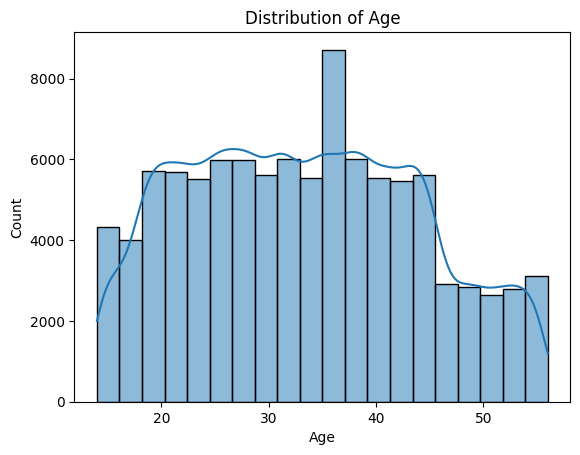

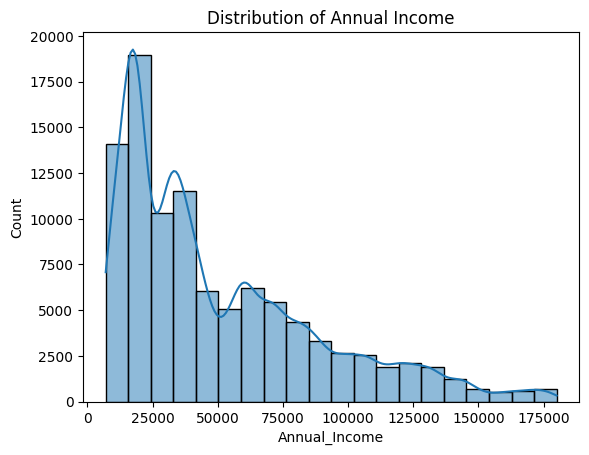

In [ ]:

# Numerical Feature Visualizations
sns.histplot(df_X['Age'], bins=20, kde=True)
plt.title('Distribution of Age')
plt.show()

sns.histplot(df_X['Annual_Income'], bins=20, kde=True)
plt.title('Distribution of Annual Income')
plt.show()


In [ ]:
df_X = pd.read_csv("/content/drive/MyDrive/df_X.csv")
df_Y = pd.read_csv("/content/drive/MyDrive/df_Y.csv")

In [ ]:
label_encoder = LabelEncoder()
df_Y['Credit_Score'] = label_encoder.fit_transform(df_Y['Credit_Score'])

In [ ]:
# Create a custom splitter based on Customer_ID and stratify based on df_Y
custom_splitter = GroupShuffleSplit(n_splits=1, test_size=0.4, random_state=42)

train_indices, val_indices, test_indices = [], [], []

for train_index, test_val_index in custom_splitter.split(df_X, df_Y, groups=df_X['Customer_ID']):
    train_indices.extend(train_index)
    test_val_indices = test_val_index

test_val_custom_splitter = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for val_index, test_index in test_val_custom_splitter.split(df_X.iloc[test_val_indices], df_Y.iloc[test_val_indices], groups=df_X.iloc[test_val_indices]['Customer_ID']):
    val_indices.extend(test_val_indices[val_index])
    test_indices.extend(test_val_indices[test_index])

X_train, y_train = df_X.iloc[train_indices], df_Y.iloc[train_indices]
X_val, y_val = df_X.iloc[val_indices], df_Y.iloc[val_indices]
X_test, y_test = df_X.iloc[test_indices], df_Y.iloc[test_indices]

In [ ]:
X_train = X_train.drop(columns='Customer_ID')
X_val = X_val.drop(columns='Customer_ID')
X_test = X_test.drop(columns='Customer_ID')

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
ovr_logistic_regression = LogisticRegression(multi_class='ovr', random_state=42)

ovr_logistic_regression.fit(X_train_scaled, y_train)

y_pred = ovr_logistic_regression.predict(X_val_scaled)

accuracy = accuracy_score(y_val, y_pred)
cr_logreg = classification_report(y_val, y_pred)

print("Model - One-vs-Rest Logistic Regression")
print("Accuracy:", accuracy)
print("Classification Report:\n", cr_logreg)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model - One-vs-Rest Logistic Regression
Accuracy: 0.6232
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.47      0.54      5906
           1       0.64      0.74      0.69     10482
           2       0.55      0.53      0.54      3612

    accuracy                           0.62     20000
   macro avg       0.61      0.58      0.59     20000
weighted avg       0.62      0.62      0.62     20000



In [ ]:
from sklearn.svm import SVC, LinearSVC

ovr_svm = LinearSVC(random_state=42)

ovr_svm.fit(X_train, y_train)

y_train_pred = ovr_svm.predict(X_train)
y_val_pred = ovr_svm.predict(X_val)
y_test_pred = ovr_svm.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Model - One-vs-Rest Linear SVM")
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model - One-vs-Rest Linear SVM
Training Accuracy: 0.5318
Validation Accuracy: 0.5206
Test Accuracy: 0.5292


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
cr_primal_svm_train = classification_report(y_train, y_train_pred)
cr_primal_svm_val = classification_report(y_val, y_val_pred)
cr_primal_svm_test = classification_report(y_test, y_test_pred)

print("Classification Report SVM Train:\n", cr_primal_svm_train)
print("Classification Report SVM Val:\n", cr_primal_svm_val)
print("Classification Report SVM Test:\n", cr_primal_svm_test)

Classification Report SVM Train:
               precision    recall  f1-score   support

           0       0.71      0.02      0.04     17288
           1       0.54      0.98      0.69     32089
           2       0.22      0.03      0.05     10623

    accuracy                           0.53     60000
   macro avg       0.49      0.34      0.26     60000
weighted avg       0.53      0.53      0.39     60000

Classification Report SVM Val:
               precision    recall  f1-score   support

           0       0.73      0.02      0.04      5906
           1       0.53      0.97      0.68     10482
           2       0.19      0.02      0.04      3612

    accuracy                           0.52     20000
   macro avg       0.48      0.34      0.26     20000
weighted avg       0.52      0.52      0.38     20000

Classification Report SVM Test:
               precision    recall  f1-score   support

           0       0.76      0.03      0.05      5804
           1       0.53      0

In [ ]:
X_dev = pd.concat([X_train, X_val], ignore_index=True)
y_dev = pd.concat([y_train, y_val], ignore_index=True)

rf_classifier = RandomForestClassifier(random_state=42)

rf_classifier.fit(X_dev, y_dev)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
cr_rf = classification_report(y_test, y_pred)

print("Model - One-vs-Rest Random Forest")
print("Accuracy:", accuracy)
print("Classification Report:\n", cr_rf)

<ipython-input-10-5668d769f1de>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_dev, y_dev)


Model - One-vs-Rest Random Forest
Accuracy: 0.7046
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.67      0.70      5804
           1       0.74      0.75      0.75     10603
           2       0.57      0.64      0.60      3593

    accuracy                           0.70     20000
   macro avg       0.68      0.68      0.68     20000
weighted avg       0.71      0.70      0.71     20000



In [ ]:
smote = SMOTE(random_state=42)
x_dev_smote, y_dev_smote = smote.fit_resample(X_dev, y_dev)
print("Label counts after random undersampling")
print(y_dev_smote.value_counts())

clf_smote = DecisionTreeClassifier(max_depth=10, random_state=42)
clf_smote.fit(x_dev_smote, y_dev_smote)

y_test_predict_clf_smote = clf_smote.predict(X_test)

print(classification_report(y_test, y_test_predict_clf_smote))

In [ ]:
score = {
    'auc': 'roc_auc',
    'average_precision': make_scorer(average_precision_score)
}

In [ ]:
scaler = StandardScaler()
X_dev_scaled = scaler.fit_transform(X_dev)
X_test_scaled = scaler.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [ ]:
param_grid = {
'max_depth': [5,6,7,8,10,12,15],
}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_dev_scaled, y_dev)

print("Best Hyperparameter value for max_depth:", grid_search.best_params_)

y_test_pred = grid_search.best_estimator_.predict(X_test_scaled)
accuracy_test = accuracy_score(y_test, y_test_pred)
print("Accuracy on Test Set:", accuracy_test)

print("Classification Report on Test Set:\n", classification_report(y_test, y_test_pred))

Best Hyperparameter value for max_depth: {'max_depth': 6}
Accuracy on Test Set: 0.70005
Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.69      0.67      0.68      5804
           1       0.76      0.72      0.74     10603
           2       0.57      0.70      0.63      3593

    accuracy                           0.70     20000
   macro avg       0.68      0.69      0.68     20000
weighted avg       0.71      0.70      0.70     20000



In [ ]:
# Random Undersampling
rus = RandomUnderSampler(random_state=42)
x_dev_undersample, y_dev_undersample = rus.fit_resample(X_dev_scaled, y_dev)
print('Shape of development dataset in default dataset: ', X_dev_scaled.shape)
print('Shape of development dataset after random undersampling: ', x_dev_undersample.shape)
# Total observations in this undersampled dataset are 42,705

unique_values, counts = np.unique(y_dev_undersample, return_counts=True)
counts_dict = dict(zip(unique_values, counts))
print("Value Counts of y_dev_undersample:")
print(counts_dict)

Shape of development dataset in default dataset:  (80000, 46)
Shape of development dataset after random undersampling:  (42705, 46)
Value Counts of y_dev_undersample:
{0: 14235, 1: 14235, 2: 14235}


In [ ]:
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42, max_depth=6), {}, cv=10, scoring='accuracy')
grid_search.fit(x_dev_undersample, y_dev_undersample)

y_test_pred = grid_search.predict(X_test_scaled)
accuracy_test = accuracy_score(y_test, y_test_pred)
print("Accuracy on Test Set:", accuracy_test)

print("Classification Report on Test Set:\n", classification_report(y_test, y_test_pred))

Accuracy on Test Set: 0.6727
Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.63      0.80      0.71      5804
           1       0.88      0.54      0.67     10603
           2       0.51      0.86      0.64      3593

    accuracy                           0.67     20000
   macro avg       0.67      0.73      0.67     20000
weighted avg       0.74      0.67      0.67     20000



In [ ]:
# Random Oversampling

ros = RandomOverSampler(random_state=42)
x_dev_oversample, y_dev_oversample = ros.fit_resample(X_dev_scaled, y_dev)
print('Shape of development dataset in default dataset: ', X_dev_scaled.shape)
print('Shape of development dataset after random oversampling: ', x_dev_oversample.shape)
# Total observations in this oversampled dataset are 42,571

unique_values, counts = np.unique(y_dev_oversample, return_counts=True)
counts_dict = dict(zip(unique_values, counts))
print("Value Counts of y_dev_oversample:")
print(counts_dict)

Shape of development dataset in default dataset:  (80000, 46)
Shape of development dataset after random oversampling:  (127713, 46)
Value Counts of y_dev_oversample:
{0: 42571, 1: 42571, 2: 42571}


In [ ]:
g3 = GridSearchCV(DecisionTreeClassifier(random_state=42, max_depth=6), {}, cv=10, scoring='accuracy')
grid_search.fit(x_dev_oversample, y_dev_oversample)

y_test_pred = grid_search.predict(X_test_scaled)
accuracy_test = accuracy_score(y_test, y_test_pred)
print("Accuracy on Test Set:", accuracy_test)

print("Classification Report on Test Set:\n", classification_report(y_test, y_test_pred))

Accuracy on Test Set: 0.6717
Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.63      0.80      0.70      5804
           1       0.87      0.54      0.66     10603
           2       0.51      0.86      0.64      3593

    accuracy                           0.67     20000
   macro avg       0.67      0.73      0.67     20000
weighted avg       0.74      0.67      0.67     20000



In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 5, 10],
}

random_forest = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(random_forest, param_grid, cv=10, scoring='accuracy')
grid_search.fit(x_dev_undersample, y_dev_undersample)
y_test_pred = grid_search.predict(X_test_scaled)

accuracy_test = accuracy_score(y_test, y_test_pred)

print("Best Parameters:", grid_search.best_params_)
print("Accuracy on Test Set:", accuracy_test)
print("Classification Report on Test Set:\n", classification_report(y_test, y_test_pred))


Best Parameters: {'max_depth': 10, 'n_estimators': 150}
Accuracy on Test Set: 0.6826
Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.65      0.78      0.71      5804
           1       0.87      0.57      0.69     10603
           2       0.51      0.85      0.64      3593

    accuracy                           0.68     20000
   macro avg       0.67      0.73      0.68     20000
weighted avg       0.74      0.68      0.69     20000



In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 5, 10],
}

random_forest = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(random_forest, param_grid, cv=10, scoring='accuracy')
grid_search.fit(x_dev_oversample, y_dev_oversample)
y_test_pred = grid_search.predict(X_test_scaled)

accuracy_test = accuracy_score(y_test, y_test_pred)

print("Best Parameters:", grid_search.best_params_)
print("Accuracy on Test Set:", accuracy_test)
print("Classification Report on Test Set:\n", classification_report(y_test, y_test_pred))

Best Parameters: {'max_depth': 10, 'n_estimators': 100}
Accuracy on Test Set: 0.6822
Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.64      0.79      0.71      5804
           1       0.87      0.57      0.69     10603
           2       0.51      0.85      0.64      3593

    accuracy                           0.68     20000
   macro avg       0.67      0.74      0.68     20000
weighted avg       0.74      0.68      0.68     20000

